In [1]:
import librosa
import scipy.signal as signal
import statistics as stats
import numpy as np
from copy import copy, deepcopy
import python_speech_features
import matplotlib.pyplot as plt
import os
import signal
from tqdm import tqdm
from pydub import AudioSegment
import librosa.display
from PIL import Image
import glob
import IPython.display
import pandas as pd
import soundfile as sf


prepro = True  # if True, run `python prepro.py` first before running `python train.py`.

vocab = u'''␀␃ !',-.:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz''' # ␀: Padding ␃: End of Sentence

    # data
data = "/data/private/voice/LJSpeech-1.0"
test_data = 'test_sents.txt'
ref_audio = 'ref1/*.wav'
Tx = 188 # Fixed length of text length.

    # signal processing
sr = 22050 # Sample rate.
n_fft = 2048 # fft points (samples)
frame_shift = 0.0125 # seconds
frame_length = 0.05 # seconds
hop_length = int(sr*frame_shift) # samples.
win_length = int(sr*frame_length) # samples.
n_mels = 80 # Number of Mel banks to generate
power = 1.2 # Exponent for amplifying the predicted magnitude
n_iter = 50 # Number of inversion iterations
preemphasis = .97 # or None
max_db = 100
ref_db = 20

# model
embed_size = 256 # alias = E
encoder_num_banks = 16
decoder_num_banks = 8
num_highwaynet_blocks = 4
r = 5 # Reduction factor.
dropout_rate = .5

# training scheme
lr = 0.001 # Initial learning rate.
logdir = "logdir"
sampledir = 'samples'
batch_size = 32
num_iterations = 1000000
# In[248]:

input_length = 16000*5
batch_size = 32
n_mels = 320
sr=22050

In [2]:
# Получаем сигнал фиксированной частоты дискретизации
y, sr = librosa.load('Test.wav', sr=sr)
x=y
# Обрезаем тишину по краям
y, _ = librosa.effects.trim(y)

# Pre-emphasis фильтр
y = np.append(y[0], y[1:] - preemphasis * y[:-1])

# Оконное преобразование Фурье
linear = librosa.stft(y=y,
                      n_fft=n_fft,
                      hop_length=hop_length,
                      win_length=win_length)

# Амплитудный спектр
mag = np.abs(linear)

# Мел-спектр
mel_basis = librosa.filters.mel(sr, n_fft, n_mels)
mel = np.dot(mel_basis, mag)

# Переводим в децибелы
mel = 20 * np.log10(np.maximum(1e-5, mel))
mag = 20 * np.log10(np.maximum(1e-5, mag))

# Нормализуем
mel = np.clip((mel - ref_db + max_db) / max_db, 1e-8, 1)
mag = np.clip((mag - ref_db + max_db) / max_db, 1e-8, 1)

# Транспонируем и приводим к нужным типам
mel = mel.T.astype(np.float32)
mag = mag.T.astype(np.float32)

# Добиваем нулями до правильных размерностей
t = mel.shape[0]
num_paddings = r - (t % r) if t % r != 0 else 0
mel = np.pad(mel, [[0, num_paddings], [0, 0]], mode="constant")
mag = np.pad(mag, [[0, num_paddings], [0, 0]], mode="constant")

# Понижаем частоту дискретизации для мел-спектра
mel = mel[::r, :]

In [3]:
IPython.display.Audio(y, rate=sr)

In [4]:
def griffin_lim(spectrogram, n_iter=n_iter):
    x_best = copy(spectrogram)
    for i in range(n_iter):
        x_t = librosa.istft(x_best,
                            hop_length,
                            win_length=win_length,
                            window="hann")
        est = librosa.stft(x_t,
                           n_fft,
                           hop_length,
                           win_length=win_length)
        phase = est / np.maximum(1e-8, np.abs(est))
        x_best = spectrogram * phase[::len(spectrogram)]
    x_t = librosa.istft(x_best,
                        hop_length,
                        win_length=win_length,
                        window="hann")
    y = np.real(x_t)
    return y

In [5]:
import scipy

In [6]:
# Транспонируем
mag = mag.T

# Денормализуем
mag = (np.clip(mag, 0, 1) * max_db) - max_db + ref_db

# Возвращаемся от децибел к аплитудам
mag = np.power(10.0, mag * 0.05)
zeros = np.zeros((1025,105))
mag = np.concatenate((mag,zeros),axis=1)
print((mag**power).shape)

# Восстанавливаем сигнал
wav = griffin_lim(mag**power)

# De-pre-emphasis фильтр
wav = scipy.signal.lfilter([1], [1, -preemphasis], wav)

(1025, 1025)


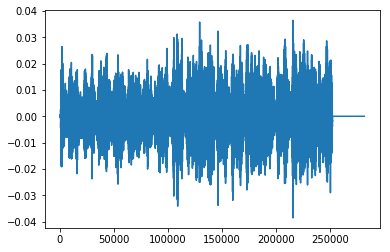

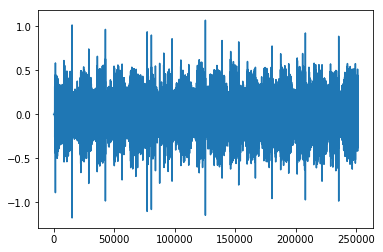

In [7]:
plt.plot(wav)
plt.show()
plt.plot(y)
plt.show()

In [8]:
IPython.display.Audio(wav, rate=sr)